# Ariel/Sat. Landslide Data Loading
The following notebook is a guide to load image data sets for model training and validation. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib
import zipfile

2024-11-20 12:39:31.977888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 12:39:31.995097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 12:39:32.000393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 12:39:32.014849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Relevant Links:
0. Trial Link just to test linkages: Please try.<br>
https://www.dropbox.com/scl/fi/ryo0gocx5ibsttv0635jg/ls_model_data_two_v2.zip?rlkey=i6fg2du9osvc0h6hpcoul1xa1&dl=0  <br>

1. Link 1 contains Training landslide images from Longxi River UAV and non-landslide images from DeepGlobe Land Cover Classification Dataset. 
Working on this - resizing to get the zip file much lower, to 1.5G.
https://www.dropbox.com/scl/fi/hgz1prxm1kx14w5riy9du/ls_model_data_three.zip?rlkey=7cv22qxmmaeofr7jn6z7iayjy&dl=0

2. ls_model_data_four: includes training images from Longxihe_UAV, Lombok, Moxitown (UAV-.2m) and Hokkaido.
https://www.dropbox.com/scl/fi/vmox93cwsx2vzrish3l63/land_ls_model_data_four.zip?rlkey=6uykz7bb0aoqbl8hgfkpt1t4f&dl=0

3. Old Test Images (Google) <br>
https://dl.dropboxusercontent.com/scl/fi/wbi8iuftwvwnflvjr15pv/test_googleimages_land.zip?rlkey=h2stfvt9ocltsog29l26wo1ls&dl=0?raw=1

4. ls_model_data_five: includes 3304 Landslide and 3940 Non Landslide images. <br>
https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1

5. New Test Set (Google) <br>
https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1


Notes per DropBox Requirements:
- Add ?raw=1 to the end of the dropbox link in the full URL link as seen below. 
- replace dropbox.com in link with "dl.dropboxusercontent.com" as seen below. 

In [3]:
# Specify the path to the zip file
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1"

In [4]:
data_dir = tf.keras.utils.get_file('ls_model_data_five.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6974


In [6]:
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide


In [10]:
# Drill into each subdirectory and list counts per folder
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    # for subitem in folder.iterdir():
    count = len(list(folder.glob('*.jpg')))
    print(f"{folder.name}: {count} .jpg images")


Contents of folder 'landslide':
landslide: 3034 .jpg images

Contents of folder 'non_landslide':
non_landslide: 3940 .jpg images


### Helper

In [9]:
## Resize and Printer Helper
def resize_show(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(500,500)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img)
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

### Review an image:

2024-11-20 12:13:23.312666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78963 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


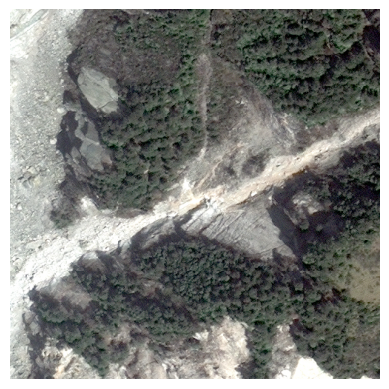

In [7]:
landslide_one = list(data_dir.glob('landslide/*'))
# PIL.Image.open(str(landslide_one[50]))
resize_show(landslide_one[150])

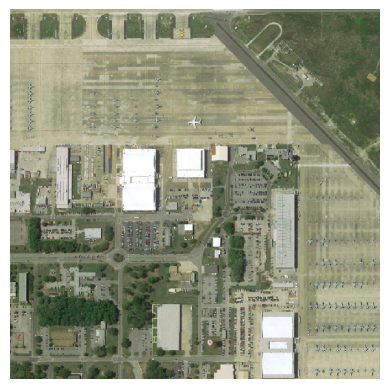

In [8]:
# landslide_one = list(data_dir.glob('landslide/*'))
# PIL.Image.open(str(landslide_one[0]))

non_landslide_img = list(data_dir.glob('non_landslide/*'))
# PIL.Image.open(str(non_landslide_img[1]))
resize_show(non_landslide_img[120])

## Separate Test Set

In [4]:
#https://www.dropbox.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"

In [5]:
data_dir_test = tf.keras.utils.get_file('test_google_images_landslide_three.zip', origin=test_dataset_url, extract=True)
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

79971293/79971293 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images


In [7]:
# Drill into each subdirectory and list files
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 47 .jpg images
  Subfolder: non-landslides
non-landslides: 67 .jpg images
  File: .DS_Store


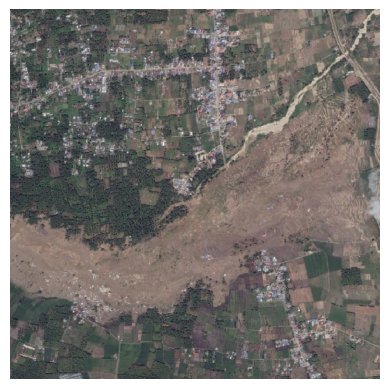

In [11]:
## Review an image
test_one = list(data_dir_test.glob('Google_Earth_Images/landslides/*'))
# PIL.Image.open(str(test_one[2]))
resize_show(test_one[3])

## **Create the model dataset**
- Added code to balance the samples, given landslide images are lower than non-landslide at this time. 

In [10]:
## Add new Import package to chunk above.  
# from collections import Counter

In [11]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

In [12]:
## Setup images into dataset to be Balanced. 
total_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='int',
    seed=512,
    image_size=(img_height, img_width),
    batch_size=1, 
    shuffle=True
)

Found 6974 files belonging to 2 classes.


In [14]:
# Step 2: Analyze class distribution
labels = np.concatenate([y for x, y in total_dataset])
class_counts = Counter(labels)
print("Class Distribution:", class_counts)

# Step 3: Balance the dataset
min_samples_per_class = min(class_counts.values())

balanced_dataset = (    ### New variable with entire image set.... 
    total_dataset.unbatch()
    .filter(lambda x, y: tf.math.reduce_sum(tf.cast(labels == y, tf.int32)) <= min_samples_per_class)
    .shuffle(buffer_size=min_samples_per_class * len(class_counts))
    .batch(batch_size)     ### Rebatch after balancing
)

Class Distribution: Counter({1: 3940, 0: 3034})


2024-11-20 12:24:22.078337: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Create Training / Validation Sets

In [21]:
print(type(balanced_dataset))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [25]:
total_batches = sum(1 for _ in balanced_dataset)
total_samples = total_batches * batch_size
print(f' Total count of items in batchs is now {total_samples}')

 Total count of items in batchs is now 3040


2024-11-20 12:31:02.023999: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
# Step 4: Split into training and validation
# total_samples = len(balanced_dataset)
train_size = int(0.8 * total_samples)

train_dataset = balanced_dataset.take(train_size)
val_dataset = balanced_dataset.skip(train_size)

# Optional: Prefetch for performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [31]:
# Step 5: Check the split
train_batches = sum(1 for _ in balanced_dataset)
train_samples = train_batches * batch_size
validation_batches = sum(1 for _ in balanced_dataset)
validation_samples = validation_batches * batch_size
print(f"Training dataset: {train_samples} batches")
print(f"Validation dataset: {validation_samples} batches")

Training dataset: 3040 batches
Validation dataset: 3040 batches


In [32]:
## Review sizes of images. 
cntr = 0
for images, labels in train_dataset:
    if cntr < 3:
        print(images.shape, labels.shape)
    else:
        break
    cntr += 1

(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)


<hr style="border:10px solid #0a0849">

**Old Code**